#### Importing the Libraries

In [12]:
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import random
import pickle
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

#### Importing the Data + Scaling

In [13]:
base_dir = "./ranzcr_clip_catheter_line_classification/"

train_df = pd.read_csv(os.path.join(base_dir, "train.csv"))
train_df.head()
#3255 unique patients, We want to make sure that each patient's images do not appear in multiple folds to avoid data leakage

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [14]:
train_df.nunique()

StudyInstanceUID              30083
ETT - Abnormal                    2
ETT - Borderline                  2
ETT - Normal                      2
NGT - Abnormal                    2
NGT - Borderline                  2
NGT - Incompletely Imaged         2
NGT - Normal                      2
CVC - Abnormal                    2
CVC - Borderline                  2
CVC - Normal                      2
Swan Ganz Catheter Present        2
PatientID                      3255
dtype: int64

In [15]:
train_df.shape
#13 - 2 = 11 labels which was also mentioned in the dataset description.
#That being said, there are two columns "StudyInstanceUID" and "PatientID" which do not hold valuable information. So, they can be dropped.

(30083, 13)

In [16]:
#some patients have over 100 images and some have only 1
train_df.PatientID.value_counts()

05029c63a    172
55073fece    167
26da0d5ad    148
8849382d0    130
34242119f    110
            ... 
ff7363658      1
2532eaa5a      1
214d9e203      1
1dc913f36      1
20fbd68fc      1
Name: PatientID, Length: 3255, dtype: int64

                  Malpositions  Number of Observations
0               ETT - Abnormal                      79
1             ETT - Borderline                    1138
2                 ETT - Normal                    7240
3               NGT - Abnormal                     279
4             NGT - Borderline                     529
5    NGT - Incompletely Imaged                    2748
6                 NGT - Normal                    4797
7               CVC - Abnormal                    3195
8             CVC - Borderline                    8460
9                 CVC - Normal                   21324
10  Swan Ganz Catheter Present                     830


<BarContainer object of 11 artists>

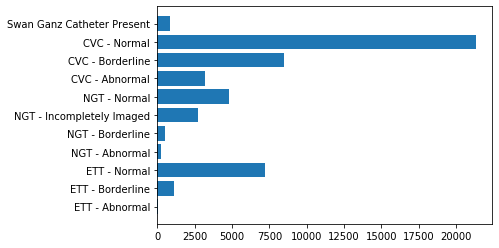

In [17]:
#plot label distrobution
categories = ['ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal','Swan Ganz Catheter Present']
categoryCounts = train_df[categories].sum(axis = 0).reset_index()
categoryCounts.columns = ['Malpositions', 'Number of Observations']
print(categoryCounts)
plt.barh(categoryCounts['Malpositions'], categoryCounts['Number of Observations'])

#So according to the graph, most of the people had Normal condition in all three criteria "CVC", "NGT", and "ETT".

In [18]:
#load x and y data
Xtrain = pickle.load(open("X.pickle", "rb"))
ytrain = pickle.load(open("y.pickle", "rb"))

In [19]:
Xtrain

array([array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 5, 54, 64, ..., 18, 19, 20],
       [ 8, 58, 71, ..., 18, 20, 20],
       [ 3, 18, 15, ...,  5,  5,  5]], dtype=uint8),
       array([[118, 111,  50, ..., 105, 121,  96],
       [107,  71,  44, ..., 145, 167, 131],
       [ 36,  41,  28, ..., 136, 143, 112],
       ...,
       [ 15,  21,  20, ..., 112, 118,  83],
       [ 15,  21,  19, ..., 109, 115,  83],
       [  9,  16,  13, ...,  69,  74,  57]], dtype=uint8),
       array([[  1,   2,   3, ...,   7,   2,   1],
       [  9,  84,  98, ..., 167,  44,   0],
       [  9, 115, 123, ..., 217,  54,   2],
       ...,
       [  9,  87,  96, ...,  10,   4,   0],
       [ 10,  91, 105, ...,  10,   4,   0],
       [  1,  27,  27, ...,   3,   1,   0]], dtype=uint8),
       array([[ 1,  1,  2, ...,  3,  3,  2],
       [ 2,  2,  3, ...,  4,  4,  1],
       [ 3,  3,  3, ...,  5,  5,  5],
       ...,
       [ 

In [20]:
Xtrain.shape #verified!

(1000,)

In [21]:
Xtrain[0].shape #verified!

(650, 650)

In [24]:
#scale to 0-1

Xtrain = np.array(Xtrain)
Xtrain_scaled = []
for pic in Xtrain:
    Xtrain_scaled.append(np.array(pic/255).astype(np.float32))
# Xtrain = []
ytrain = ytrain.astype(np.float32)

In [25]:
Xtrain_scaled

[array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.01960784, 0.21176471, 0.2509804 , ..., 0.07058824, 0.07450981,
         0.07843138],
        [0.03137255, 0.22745098, 0.2784314 , ..., 0.07058824, 0.07843138,
         0.07843138],
        [0.01176471, 0.07058824, 0.05882353, ..., 0.01960784, 0.01960784,
         0.01960784]], dtype=float32),
 array([[0.4627451 , 0.43529412, 0.19607843, ..., 0.4117647 , 0.4745098 ,
         0.3764706 ],
        [0.41960785, 0.2784314 , 0.17254902, ..., 0.5686275 , 0.654902  ,
         0.5137255 ],
        [0.14117648, 0.16078432, 0.10980392, ..., 0.53333336, 0.56078434,
         0.4392157 ],
        ...,
        [0.05882353, 0.08235294, 0.07843138, ..., 0.4392157 , 0.4627451 ,
         0.3254902 

In [26]:
len(Xtrain_scaled) #verified!

1000

In [28]:
ytrain.shape #verified!

(1000,)

In [29]:
ytrain

array([  1.,   1.,   6.,   3.,   6.,   1., 159.,   1.,   4.,   1.,  73.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   3.,  73.,
        60.,  77.,  60.,  79.,   4.,  75.,   1.,  73.,   6.,   1.,   3.,
         1.,   3.,  71.,   1.,  71., 142.,  21.,   3.,   1.,  36.,  86.,
         1.,   1.,   1.,  74.,   6.,   1.,  73.,   1.,  73.,   6.,  86.,
        60.,   1.,   4.,   6.,  60.,   1.,   1.,  11.,  60.,   1.,   1.,
         3.,   1.,   6.,   1.,   3.,   1.,   1.,   1.,   3.,  90.,   6.,
         6.,  36.,   1.,   1.,   3.,   1.,   1.,  84.,   1.,  91.,  88.,
        71.,   1.,   2.,   1.,   1.,   1.,   1.,   1.,  60.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,  64.,  86.,  87.,   1.,   3., 133.,
        86.,   3.,  92., 187.,   3.,   1.,  14., 116.,   1.,   6.,  62.,
         1.,  62.,  80.,  59.,   1.,   1.,   1.,   1.,   1.,  65.,   1.,
         3.,   1.,   1.,   1.,   1.,   1.,   6., 142.,   1.,  34.,  75.,
        77.,  60.,   3.,  92.,   1.,   1.,   3.,   

In [30]:
#np.expand_dims(pic, axis=2)
Xtrain_scaled = np.array(Xtrain_scaled).reshape((-1, 650, 650, 1)) #reshaping the data to numpy array with size #n*650*650*1 (since pictures are in gryscale -> black and white -> 1 not 3)

In [32]:
print(np.array(Xtrain_scaled).shape) #verified!

(1000, 650, 650, 1)


#### Model

In [44]:
np.unique(ytrain)

array([  1.,   2.,   3.,   4.,   6.,   7.,   9.,  10.,  11.,  12.,  14.,
        16.,  18.,  19.,  21.,  23.,  24.,  25.,  28.,  34.,  35.,  36.,
        41.,  50.,  52.,  53.,  59.,  60.,  62.,  64.,  65.,  66.,  67.,
        71.,  73.,  74.,  75.,  77.,  78.,  79.,  80.,  84.,  86.,  87.,
        88.,  90.,  91.,  92.,  93.,  95., 102., 104., 105., 109., 114.,
       116., 120., 125., 133., 142., 144., 146., 148., 150., 152., 157.,
       159., 161., 169., 187., 189., 196., 197.], dtype=float32)

In [45]:
# build a sequential model

model = Sequential()
# model.add(InputLayer(input_shape = (650, 650, 1), batch_size = 32))

# 1st conv block
model.add(Conv2D(25, (5, 5), activation = 'relu', strides = (1, 1), input_shape = (650, 650, 1))) #padding = 'same'     #or adding "input_shape" instead of defining a seperate "InputLayer" 
model.add(MaxPool2D(pool_size = (2, 2)))
# 2nd conv block
model.add(Conv2D(50, (5, 5), activation = 'relu', strides = (2, 2)))
model.add(MaxPool2D(pool_size = (2, 2)))
# model.add(BatchNormalization()) #I beleive one batchnormalization block is enough.
# 3rd conv block
model.add(Conv2D(70, (3, 3), activation = 'relu', strides = (2, 2)))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(BatchNormalization())
# ANN block
model.add(Flatten())
model.add(Dense(units = 100, activation = 'relu'))
model.add(Dense(units = 50, activation = 'relu'))
model.add(Dropout(0.25))
# output layer
model.add(Dense(units = 211, activation = 'softmax'))
 
# compile model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy']) #categorical_crossentropy

model.summary()

#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)


# fit on data for 30 epochs
model.fit(x = Xtrain_scaled, y = ytrain, epochs = 100, batch_size = 32, validation_split = 0.2, callbacks = [early_stop])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 646, 646, 25)      650       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 323, 323, 25)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 160, 160, 50)      31300     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 80, 80, 50)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 39, 39, 70)        31570     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 19, 19, 70)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 19, 19, 70)       